# Basic tutorial: image data
#### Author: Matteo Caorsi

This short tutorial provides you with the basic functioning of *giotto-deep* API.

The main steps of the tutorial are the following:
 1. creation of a dataset
 2. creation of a model
 3. define metrics and losses
 4. run benchmarks
 5. visualise results interactively

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

import torch
from torch import nn

from gdeep.models import FFNet

from gdeep.visualisation import  persistence_diagrams_of_activations

from torch.utils.tensorboard import SummaryWriter
from gdeep.data import TorchDataLoader


from gtda.diagrams import BettiCurve

from gtda.plotting import plot_betti_surfaces

# Initialize the tensorboard writer

In order to analyse the reuslts of your models, you need to start tensorboard.
On the terminal, move inside the `/example` folder. There run the following command:

```
tensorboard --logdir=runs
```

Then go [here](http://localhost:6006/) after the training to see all the visualisation results.

In [2]:
writer = SummaryWriter()

# Create your dataset

In [3]:
from torch.utils.data.sampler import SubsetRandomSampler
dl = TorchDataLoader(name="CIFAR10")

# use only 320 images from cifar10
train_indices = list(range(32*10))
dl_tr, dl_ts = dl.build_dataloader(batch_size=32, sampler=SubsetRandomSampler(train_indices))

Files already downloaded and verified
Files already downloaded and verified


## Define and train your model

In [4]:
import torchvision.models as models
from gdeep.pipeline import Pipeline

# wrap a sequential model in a torch nn.Module
class model3(nn.Module):
    def __init__(self):
        super(model3, self).__init__()
        self.seqmodel = nn.Sequential(models.resnet18(pretrained=True), nn.Linear(1000,10))
    def forward(self, X):
        return self.seqmodel(X)

model = model3()

No TPUs...


In [5]:
from torch.optim import SGD

# print(model)
loss_fn = nn.CrossEntropyLoss()

pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)

# train the model
pipe.train(SGD, 3, False, {"lr":0.01}, {"batch_size":32, "sampler":SubsetRandomSampler(train_indices)})



Epoch 1
-------------------------------
No TPUs
Batch training loss:  3.2025386095046997  	Batch training accuracy:  16.796875  	[ 8 / 8 ]                              
Time taken for this epoch: 3s
No TPUs
Validation results: 
 Accuracy: 9.375000%,                 Avg loss: 4.675710 

Epoch 2
-------------------------------
No TPUs
Batch training loss:  2.905037134885788  	Batch training accuracy:  26.953125  	[ 8 / 8 ]                              
Time taken for this epoch: 3s
No TPUs
Validation results: 
 Accuracy: 6.250000%,                 Avg loss: 3.128407 

Epoch 3
-------------------------------
No TPUs
Batch training loss:  2.086886078119278  	Batch training accuracy:  41.015625  	[ 8 / 8 ]                               
Time taken for this epoch: 3s
No TPUs
Validation results: 
 Accuracy: 17.187500%,                 Avg loss: 4.096832 



(4.096831679344177, 17.1875)

# Simply use interpretability tools

/Users/matteocaorsi/anaconda3/lib/python3.6/site-packages/captum/_utils/gradient.py:59: UserWarning:

Input Tensor 0 did not already require gradients, required_grads has been set automatically.

/Users/matteocaorsi/anaconda3/lib/python3.6/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning:

Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished

/Users/matteocaorsi/anaconda3/lib/python3.6/site-packages/torch/nn/modules/module.py:974: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



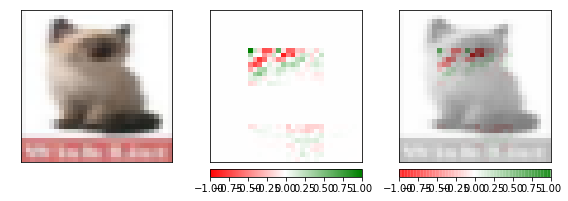

In [10]:
from gdeep.analysis.interpretability import Interpreter
from gdeep.visualisation import Visualiser

inter = Interpreter(pipe.model, method="GuidedGradCam")
output = inter.interpret_image(next(iter(dl_tr))[0][0].reshape(1,3,32,32), 
                      1, pipe.model.seqmodel[0].layer2[0].conv1);

# visualise the interpreter
vs = Visualiser(pipe)
vs.plot_interpreter_image(inter);

# Extract inner data from your models

In [11]:
from gdeep.models import ModelExtractor

me = ModelExtractor(pipe.model, loss_fn)

lista = me.get_layers_param()

for k, item in lista.items():
    print(k,item.shape)


seqmodel.0.conv1.weight torch.Size([64, 3, 7, 7])
seqmodel.0.bn1.weight torch.Size([64])
seqmodel.0.bn1.bias torch.Size([64])
seqmodel.0.bn1.running_mean torch.Size([64])
seqmodel.0.bn1.running_var torch.Size([64])
seqmodel.0.bn1.num_batches_tracked torch.Size([])
seqmodel.0.layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
seqmodel.0.layer1.0.bn1.weight torch.Size([64])
seqmodel.0.layer1.0.bn1.bias torch.Size([64])
seqmodel.0.layer1.0.bn1.running_mean torch.Size([64])
seqmodel.0.layer1.0.bn1.running_var torch.Size([64])
seqmodel.0.layer1.0.bn1.num_batches_tracked torch.Size([])
seqmodel.0.layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
seqmodel.0.layer1.0.bn2.weight torch.Size([64])
seqmodel.0.layer1.0.bn2.bias torch.Size([64])
seqmodel.0.layer1.0.bn2.running_mean torch.Size([64])
seqmodel.0.layer1.0.bn2.running_var torch.Size([64])
seqmodel.0.layer1.0.bn2.num_batches_tracked torch.Size([])
seqmodel.0.layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
seqmodel.0.layer1.1.bn1.weight torc

In [12]:
x = next(iter(dl_tr))[0][0]
if x.dtype is not torch.int64:
    res = me.get_decision_boundary(x, n_epochs=1)
    res.shape

Executing the decision boundary computations:


In [13]:
x = next(iter(dl_tr))[0]
list_activations = me.get_activations(x)
len(list_activations)


79

In [14]:
x, target = next(iter(dl_tr))
if x.dtype is torch.float:
    for gradient in me.get_gradients(x, target=target)[1]:
        print(gradient.shape)

torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 64, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
t

# Visualise activations and other topological aspects of your model

In [15]:

# vs.plot_data_model()
# vs.plot_activations(x)
vs.plot_persistence_diagrams(x)


# Evaluate model

In the next section we compute the confusion matrix on the entire training dataloader.

In [16]:
pipe.evaluate_classification(10)

10it [00:00, 14.36it/s]


(25.937500000000004,
 3.6003201961517335,
 array([[ 0.,  2.,  0.,  0.,  0.,  1.,  0.,  0., 21.,  1.],
        [ 0., 15.,  0.,  0.,  2.,  2.,  3.,  0., 12., 13.],
        [ 0.,  3.,  2.,  0.,  0.,  6.,  1.,  0.,  9.,  8.],
        [ 0.,  4.,  0.,  1.,  2.,  5.,  3.,  0.,  9.,  8.],
        [ 0.,  1.,  0.,  0.,  5.,  9.,  0.,  1.,  2.,  9.],
        [ 0.,  1.,  0.,  0.,  2., 16.,  1.,  0.,  0.,  7.],
        [ 1.,  1.,  2.,  0.,  3.,  7.,  5.,  1.,  4., 13.],
        [ 0.,  0.,  0.,  1.,  3.,  9.,  0.,  2.,  7.,  7.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 25.,  1.],
        [ 0.,  2.,  0.,  0.,  1.,  4.,  0.,  1., 20., 12.]]))